<a href="https://www.kaggle.com/code/jhtkoo0426/house-price-regression?scriptVersionId=147879913" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## 1. Prerequisites

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor, DMatrix
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
# Fixed variables
RANDOM_STATE = 12

# Path variables
TRAIN_CSV_PATH = "/kaggle/input/house-prices-advanced-regression-techniques/train.csv"
TEST_CSV_PATH = "/kaggle/input/house-prices-advanced-regression-techniques/test.csv"

## 2. Understanding the dataset
In this section, we attempt to understand column data types and their correlations amongst each other.

### 2.1 Basic information
Retrieve information about the dataset, including the index dtype and columns and non-null values.

In [3]:
data = pd.read_csv(TRAIN_CSV_PATH)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

The dataset consists of 81 columns, in which 43 columns are of the `object` type. These columns are considered as non-numerical, which would hinder our analysis process.

### 2.2 Correlation between variables

In this section, we ignore all non-numerical columns in the dataset. Non-numerical columns will be preprocessed in our pipeline in later sections of this notebook.

Additionally, we create a heatmap of the 20 most-correlated variables.

In [4]:
numerical_columns = data.select_dtypes(np.number).columns
corr_mat = data[numerical_columns].corr()

In [5]:
corr_mat_sorted = corr_mat['SalePrice'].sort_values(ascending=False)
most_corr = corr_mat_sorted.head(20)
corr_mat = data[most_corr.index].corr()

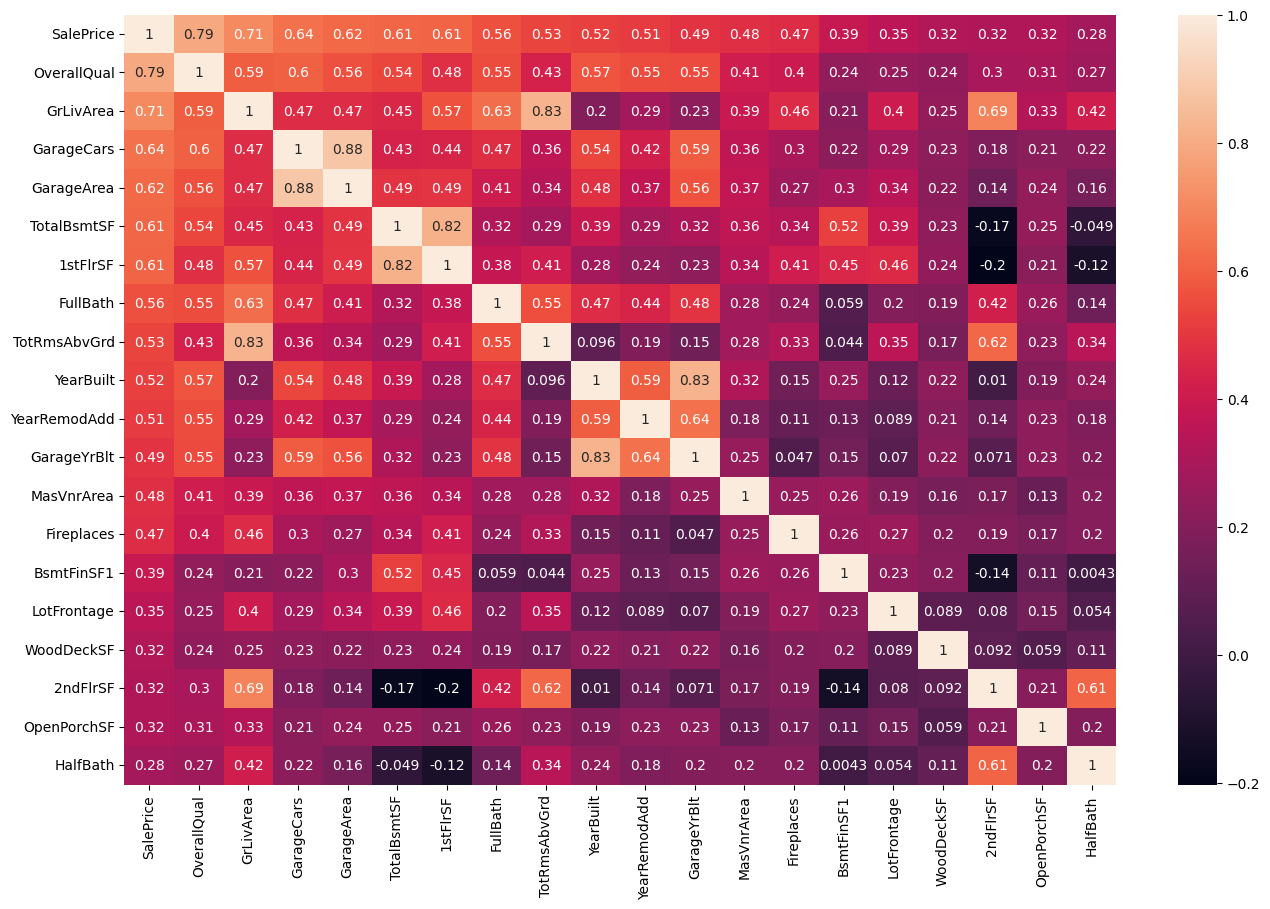

In [6]:
plt.figure(figsize=(16, 10))
sns.heatmap(corr_mat, annot=True)
plt.show()

## 3. Data Preprocessing
In this section, we will apply common data cleaning techniques to our dataset using a pipeline approach.

### 3.1 Dealing with missing values
Find out which columns contain `null` values.

In [7]:
null_columns = data.isna().mean().sort_values(ascending=False)
null_columns[null_columns > 0]

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
MasVnrType      0.597260
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageCond      0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtQual        0.025342
BsmtCond        0.025342
BsmtFinType1    0.025342
MasVnrArea      0.005479
Electrical      0.000685
dtype: float64

This reveals that a minimum of 40% of null values are present in at least 6 columns of the dataset, namely `PoolQC`, `MiscFeature`, `Alley`, `Fence`, `MasVnrType` and `FireplaceQu`.

Therefore, we will be removing these columns from the dataset, as they provide little to no value to our analysis.

Note: We also remove the `Id` column as well.

### 3.2 Dropping features
We create our first class (to be used in our pipeline) that removes the aforementioned columns from the dataset.

In [8]:
class DropFeatures(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        col_labels = ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu']
        X = X.drop(col_labels, axis=1)
        return X

### 3.3 Dealing with outliers
In this section, we will use the **z-score** (standard score) to understand how far each data point is from the mean. This will form the next phase in our pipeline.

Note: At the moment, we do not consider whether the data is **skewed** or not. This is something that we can improve upon in further versions.

In [9]:
data_z_score = data[numerical_columns].apply(zscore)
data_z_score.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,-1.730865,0.073375,NaN,-0.207142,0.651479,-0.517200,1.050994,0.878668,NaN,0.575425,...,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.347273
1,-1.728492,-0.872563,NaN,-0.091886,-0.071836,2.179628,0.156734,-0.429577,NaN,1.171992,...,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,0.007288
2,-1.726120,0.073375,NaN,0.073480,0.651479,-0.517200,0.984752,0.830215,NaN,0.092907,...,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.536154
3,-1.723747,0.309859,NaN,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,NaN,-0.499274,...,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,-0.515281
4,-1.721374,0.073375,NaN,0.375148,1.374795,-0.517200,0.951632,0.733308,NaN,0.463568,...,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,0.869843


We will use a threshold of 2 standard deviations away from the mean as our outlier detector.

In [10]:
class RemoveOutliers(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        numrical_col = X.select_dtypes(np.number).columns
        for column in numrical_col :
            # To Find IQR
            percentile25 = X[column].quantile(0.25)
            percentile75 = X[column].quantile(0.75)
            iqr = percentile75 - percentile25
            upper_limit = percentile75 + 1.5 * iqr
            lower_limit = percentile25 - 1.5 * iqr
            X[column] = np.where(
                X[column] > upper_limit,
                upper_limit,
                np.where(
                    X[column] < lower_limit,
                    lower_limit,
                    X[column]
                )
            )
        return X
        

### 3.4 Remaining cleaning techniques
Filling `null` values, etc.

In [11]:
class Cleaning(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.select_dtypes(np.number)    # Retain numerical columns only
        X = X.fillna(0)                   # Replacing NULL values with 0
        return X

### 3.n Combining classes into a single pipeline

In [12]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('drop', DropFeatures()),
    ('outliers', RemoveOutliers()),
    ('clean', Cleaning()),
])

## 4. Partitioning datasets and performing data preprocessing using pipeline

In [13]:
X = data.drop(['SalePrice'], axis=1)
y = data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

## 5. Model training & selection

In [15]:
def train_models(X_train, X_test, y_train, y_test):
    model_dict = {
        "linear": LinearRegression(),
        "Ridge": Ridge(alpha=0.2),
        "KNN": KNeighborsRegressor(n_jobs=-1, n_neighbors=4),
        "XGB": XGBRegressor(random_state=42),
        "light": LGBMRegressor(random_state=42),
        "Cat": CatBoostRegressor(random_state=42, loss_function='RMSE', verbose=False)
    }

    for model_name, model in model_dict.items() :
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        print(f"Training loss for model {model_name}: {mean_squared_error(y_test, pred, squared=False)}")

In [16]:
train_models(X_train, X_test, y_train, y_test)

Training loss for model linear: 34861.724592910316
Training loss for model Ridge: 34861.57745116582
Training loss for model KNN: 47296.23236489078
Training loss for model XGB: 28005.903013212945
Training loss for model light: 30008.012225947343
Training loss for model Cat: 28494.949042673175


We conclude that the `XGB Regressor` model performs the best for out dataset. Therefore, we will be training it for submission.

## 6. Create submission

In [17]:
test_df = pd.read_csv(TEST_CSV_PATH)
submission_df = test_df[['Id']]
test_df = pipeline.fit_transform(test_df)

In [18]:
model = CatBoostRegressor(random_state=42, verbose=False, loss_function='RMSE')
model.fit(X_train, y_train)

predictions = model.predict(test_df)
predictions

array([121041.27809802, 162461.47860754, 187472.80429525, ...,
       194706.40264735, 120478.82286638, 229809.70005707])

In [19]:
submission_df['SalePrice'] = predictions
submission_df = submission_df.set_index('Id')
submission = submission_df.to_csv("submission.csv", encoding='utf-8')

In [20]:
!head submission.csv

Id,SalePrice
1461,121041.27809801768
1462,162461.47860753525
1463,187472.80429525036
1464,195613.40947417205
1465,191594.82967343993
1466,177235.2365562883
1467,177190.80768962682
1468,168829.5798067852
1469,175865.22334973232


## Appendix: References
- https://www.kaggle.com/code/theusman/easy-and-accurate-model-among-top-20#Feature-Droping-😥😥❄❄